In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

from hgpflow_v2.performance.jet_helper import JetHelper, compute_jets
import uproot
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [3]:
fp = '...'
tree = uproot.open(fp)['events']

In [4]:
cluster_vars = [
    'PandoraClusters/PandoraClusters.energy',
    'PandoraClusters/PandoraClusters.position.x',
    'PandoraClusters/PandoraClusters.position.y',
    'PandoraClusters/PandoraClusters.position.z',
]

cluster_data = tree.arrays(cluster_vars, library='np')

cluster_data = {k.split(".")[-1]: v for k, v in cluster_data.items()}

In [5]:
cluster_data['eta'] =  np.array([-np.log(np.tan(np.arctan2(np.sqrt(x**2 + y**2), z) / 2.0)) for x, y, z in zip(cluster_data['x'], cluster_data['y'], cluster_data['z'])], dtype=object)
cluster_data['phi'] = np.array([np.arctan2(y, x) for x, y in zip(cluster_data['x'], cluster_data['y'])], dtype=object)
cluster_data['pt'] = np.array([e / np.cosh(eta) for e, eta in zip(cluster_data['energy'], cluster_data['eta'])], dtype=object)

In [ ]:
jet_obj = JetHelper(radius=0.7, algo='genkt')

cluster_jets = compute_jets(jet_obj, 
    cluster_data['pt'], cluster_data['eta'],
    cluster_data['phi'], cluster_data['energy'], 
    fourth_name='E', n_procs=0, store_constituent_idxs=True)

In [7]:
### store, for each cluster, its corresponding jet index and properties
cluster_jet_idx = []
cluster_jet_pt = []
cluster_jet_eta = []
cluster_jet_phi = []
cluster_jet_energy = []

for ev in tqdm.tqdm(range(len(cluster_data['pt']))):

    cluster_jet_idx_ev    = np.full(len(cluster_data['pt'][ev]), -9999, dtype=int)
    cluster_jet_pt_ev     = -9999*np.ones(len(cluster_data['pt'][ev]), dtype=float)
    cluster_jet_eta_ev    = -9999*np.ones(len(cluster_data['pt'][ev]), dtype=float)
    cluster_jet_phi_ev    = -9999*np.ones(len(cluster_data['pt'][ev]), dtype=float)
    cluster_jet_energy_ev = -9999*np.ones(len(cluster_data['pt'][ev]), dtype=float)

    for jet_idx, jet in enumerate(cluster_jets[ev]):
        cluster_indices = jet.constituent_idxs
        assert np.all(cluster_jet_idx_ev[cluster_indices] == -9999), "Cluster assigned to multiple jets"
        cluster_jet_idx_ev[cluster_indices] = jet_idx
        cluster_jet_pt_ev[cluster_indices] = jet.pt
        cluster_jet_eta_ev[cluster_indices] = jet.eta
        cluster_jet_phi_ev[cluster_indices] = jet.phi_std
        cluster_jet_energy_ev[cluster_indices] = jet.e

    cluster_jet_idx.append(cluster_jet_idx_ev)
    cluster_jet_pt.append(cluster_jet_pt_ev)
    cluster_jet_eta.append(cluster_jet_eta_ev)
    cluster_jet_phi.append(cluster_jet_phi_ev)
    cluster_jet_energy.append(cluster_jet_energy_ev)

cluster_data['jet_idx'] = np.array(cluster_jet_idx, dtype=object)
cluster_data['jet_pt'] = np.array(cluster_jet_pt, dtype=object)
cluster_data['jet_eta'] = np.array(cluster_jet_eta, dtype=object)
cluster_data['jet_phi'] = np.array(cluster_jet_phi, dtype=object)
cluster_data['jet_energy'] = np.array(cluster_jet_energy, dtype=object)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
def event_display(ev, bad_cluster_idxs=None):

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    color_fn = lambda idx: 'red' if idx == 0 else 'blue' if idx == 1 else 'black'

    for i, jet in enumerate(cluster_jets[ev]):
        if i > 1:
            break
        color = color_fn(i)
        label = 'lead' if i == 0 else 'sublead'
        label =  label + f', $p_T$={jet.pt:.2f} GeV'
        ax.add_patch(Circle((jet.eta, jet.phi_std), 0.7, color=color, label=label, fill=False, lw=1, alpha=0.5))

    cluster_colors = [color_fn(jet_idx) for jet_idx in cluster_data['jet_idx'][ev]]
    ax.scatter(cluster_data['eta'][ev], cluster_data['phi'][ev], s=cluster_data['energy'][ev]*30, alpha=0.5, label='clusters', color=cluster_colors)  
    ax.scatter([], [], s=0, label=f'Event {ev}')

    # bad cluster
    if bad_cluster_idxs is not None:
        ax.scatter(cluster_data['eta'][ev][bad_cluster_idxs], cluster_data['phi'][ev][bad_cluster_idxs], 
            s=cluster_data['energy'][ev][bad_cluster_idxs]*30, alpha=0.8, label='bad cluster', color='magenta', facecolors='none')

    ax.set_xlabel('$\eta$')
    ax.set_ylabel('$\phi$')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_aspect('equal')
    # legend above plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)

    plt.show()

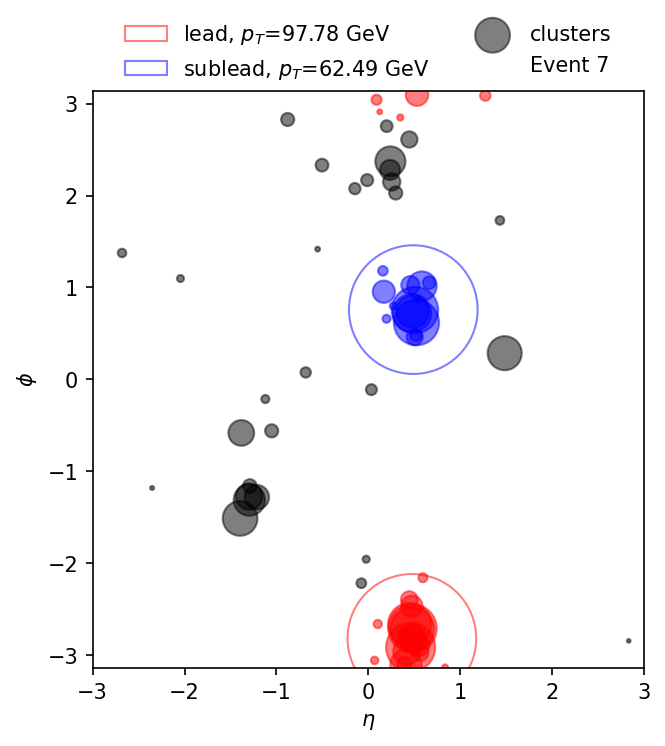

In [16]:
event_display(7)

# Save file

In [141]:
with uproot.recreate(fp.replace('.root', '_cluster_jet_index.root')) as f:
    f['cluster_data'] = cluster_data
    f['cluster_data'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nenergy              | int32_t                  | AsDtype('>i4')
energy               | double[]                 | AsJagged(AsDtype('>f8'))
nx                   | int32_t                  | AsDtype('>i4')
x                    | double[]                 | AsJagged(AsDtype('>f8'))
ny                   | int32_t                  | AsDtype('>i4')
y                    | double[]                 | AsJagged(AsDtype('>f8'))
nz                   | int32_t                  | AsDtype('>i4')
z                    | double[]                 | AsJagged(AsDtype('>f8'))
neta                 | int32_t                  | AsDtype('>i4')
eta                  | double[]                 | AsJagged(AsDtype('>f8'))
nphi                 | int32_t                  | AsDtype('>i4')
phi                  | double[]                 | AsJagged(AsDtype('>f8')

### Check that it worked

In [143]:
new_tree = uproot.open('...')['cluster_data']

In [149]:
cluster_etas = new_tree['eta'].array(library='np')
cluster_jet_etas = new_tree['jet_eta'].array(library='np')

In [150]:
cluster_etas_flat = np.hstack(cluster_etas)
cluster_jet_etas_flat = np.hstack(cluster_jet_etas)

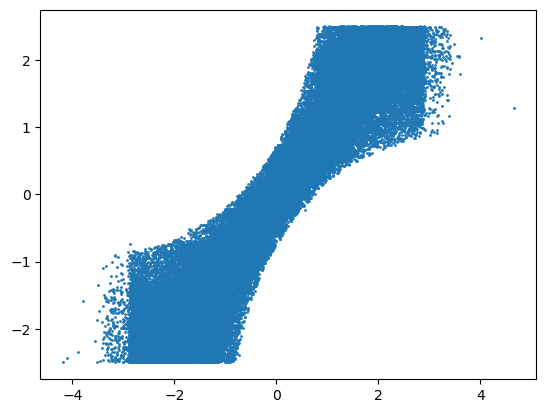

In [155]:
plt.scatter(cluster_etas_flat[cluster_jet_etas_flat > -9999], cluster_jet_etas_flat[cluster_jet_etas_flat > -9999], s=1)